In [55]:
import pandas as pd
import glob
import json
import dotted # https://pypi.org/project/dotted-notation/
import re
import matplotlib.pyplot as plt
import json

from pathlib import Path
import seaborn as sns

In [56]:
import lib.datasciencetoolbelt as dstools
from lib.resultstorage import ResultStorage

In [57]:
#%matplotlib qt
%matplotlib inline

#  Dependencies

In [58]:
import itertools

def filter_by_index_value(df, level, filter):
    """Return a new df that only contains rows whose MultiIndex column `level`'s value passes `filter`"""
    return df[df.index.get_level_values(level).map(filter)]

def remove_index_dimension(df, level, value):
    """Reduce dimensionality of a dataframe by filtering by and subsequently dropping one of its index levels.
    
    df is assumed to be a multi-indexed pd.DataFrame.
    First, filter the data frame so that we only keep rows whose index tuple has value `value` at level `level`.
    Now the resulting data frame only has a single value at the level.
    Thus remove that level from the index.
    Voila: dimensionality reduced.
    """
    df = df[df.index.get_level_values(level) == value]
    assert set(df.index.get_level_values(level)) == {value}
    df.index = df.index.droplevel(level)
    return df

def _test_remove_index_dimension():
    data = [{"favnum": n, "favletter": l, "id": id} for id, (n, l) in enumerate(itertools.product([23,42],["a", "b"]))]
    d = pd.DataFrame(data).set_index(["favnum", "favletter"])
    display(d)
    display(remove_index_dimension(d, "favnum", 23))
    display(remove_index_dimension(d, "favletter", "b"))
    
_test_remove_index_dimension()

id
favnum favletter    
23     a           0
       b           1
42     a           2
       b           3

,id
favletter,
a,0
b,1


,id
favnum,
23,1
42,3


In [59]:
def level_values_sorted_unique(df, level):
    """Returns the sorted unique values of a DataFrame's multi-index at level `level`"""
    return sorted(list(set(df.index.get_level_values(level))))

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class FactorizedDataFrameItem(AttrDict):
    @property
    def title(self):
        if self.fdf.row and self.fdf.col:
            return f"{self.fdf.row}={self.rv}|{self.fdf.col}={self.cv}"
        elif self.fdf.row:
            return f"{self.fdf.row}={self.rv}"
        elif self.fdf.col:
            return f"{self.fdf.col}={self.cv}"
        else:
            return ""
            
        
class FactorizedDataFrame:
    def __init__(self, data, row, col):
        self.data = data
        self.col = col
        self.row = row

        self.col_values = [None] if not self.col else level_values_sorted_unique(self.data, self.col)
        self.row_values = [None] if not self.row else level_values_sorted_unique(self.data, self.row)
        
    def iter_factorized(self):
        for ci, c in enumerate(self.col_values):
            for ri, r in enumerate(self.row_values):
                d = self.data.copy()
                if c:
                    d = remove_index_dimension(d, self.col, c)
                if r:
                    d = remove_index_dimension(d, self.row, r)
                # display(d)
            
                context = FactorizedDataFrameItem({
                    "fdf": self,
                    "d": d,
                    "ri": ri,
                    "rv": r,
                    "ci": ci,
                    "cv": c,
                    "is_last_row": ri == len(self.row_values)-1,
                    "is_last_col": ci == len(self.col_values)-1,
                })
                yield context
                

def factorplot(data=None, row=None, col=None, plot=None, subplots_kw={}):
    """Factorizez MultiIndex'ed DataFrame `data`, then invokes `plot` for each FactorizedDataFrameItem"""
    
    fdf = FactorizedDataFrame(data, row, col)
    
    subplots_kw = {
        "gridspec_kw": {'hspace': 1},
        **subplots_kw,
        "squeeze": False, # axes should always be two-dimensional
    }

    fig, axes = plt.subplots(len(fdf.row_values), len(fdf.col_values), **subplots_kw)

    for f in fdf.iter_factorized():
        ax = axes[f.ri, f.ci]
        ax.set_title(f.title)
        legend = f.ri == len(fdf.row_values)-1 and f.ci == len(fdf.col_values)-1
        plot(f, ax, legend)
        if legend:
            plt.legend(loc='lower left', bbox_to_anchor=(1,0.5))

# End Dependencies

In [60]:
dstools.setup({
    "seaborn_context": "talk",
    "savefig": {
        "enable": True,
        "dir": Path("./postprocess_results"),
    }
})
result_storage = ResultStorage(Path("./results"))

Exception: can only setup once

In [61]:
id_vars__dottedpath_and_shortname_and_type = [
#     ('result.identity', "benchmark", str),  
#     ("storage_stack.identity", "storage_stack", str),
    ("result.fio_config.numjobs", "numjobs", int),
]
id_vars = [p[1] for p in id_vars__dottedpath_and_shortname_and_type]

def extract_id_var_values(output_json):
    d = output_json
    id_var_values = {}
    for dp, sn, ty in id_vars__dottedpath_and_shortname_and_type: 
        v = dotted.get(d, dp)
        if not v:
            raise Exception(f"{d['file']}: dotted path {dp} not found")
        if sn in id_var_values:
            raise Exception(f"duplicate shortname {sn}")
        try:
            id_var_values[sn] = ty(v)
        except ValueError as e:
            raise Exception(f"cannot parse v={v!r}") from e
    return id_var_values


def get_fio_write_metrics(output_json):
    d = output_json
    jobs = dotted.get(d, "fio_jsonplus.jobs")
    assert len(jobs) == 1
    j0 = jobs[0]
    jw = jobs[0]["write"]
    return {
        "w_iops_mean": jw["iops_mean"],
        "w_iops_stddev": jw["iops_stddev"],
        "w_lat_mean": dotted.get(jw, "lat_ns.mean"),
        "w_lat_stddev": dotted.get(jw, "lat_ns.stddev"),
    }


def to_row_dict(output_json):
    try:
        r = {}
        for k, v in dotted.get(output_json, "result.latency_analysis").items():
            assert k[0] == '@'
            k = k[1:] # strip leading @
            assert k not in r
            r[k] = v

        r = {
            **extract_id_var_values(output_json),
            "fio_metrics": get_fio_write_metrics(output_json['result']),
            
            # cpu stats
            "cpu": output_json["result"]["cpu_time"]["allcpu"],
            **r,
        }
        return r
    except:
        print(json.dumps(output_json))
        raise

rows = [to_row_dict(j) for j in result_storage.iter_results("zillwb_latency_analysis__v3")]

In [62]:
df = pd.DataFrame.from_dict(rows)
df = df.set_index(id_vars)
df = df.sort_index()
display(df)
# display(df / 1_000_000)
# compute zfs write breakdown

,fio_metrics,cpu,zfs_write,zfs_write_count,zil_commit,zfs_log_write,zil_fill_commit_list,zillwb_commit_waiter__issue_cv,zillwb_commit_waiter__timeout_cv,zillwb_lwb_write_issue,last_lwb_latency,lwb_issue_count,pmem_submit_bio
numjobs,,,,,,,,,,,,,
1,"{'w_iops_mean': 11380.0, 'w_iops_stddev': 3895...","{'user': 2.099999999976717, 'nice': 0.0, 'syst...",715097234,11827,546042601,17943604,6653475,348104843,62551904,82042833,27013,12587,86312255
2,"{'w_iops_mean': 26065.07563, 'w_iops_stddev': ...","{'user': 3.7899999999790452, 'nice': 0.0, 'sys...",1440506528,22238,1098400183,39773531,14905674,600984455,112034942,142827445,25211,22247,149311482
3,"{'w_iops_mean': 48286.302521, 'w_iops_stddev':...","{'user': 4.2000000000116415, 'nice': 0.0, 'sys...",2007502374,26805,1510441715,57207049,20166496,790972537,156135117,204873523,27184,26814,188071569
4,"{'w_iops_mean': 58379.260504, 'w_iops_stddev':...","{'user': 6.630000000004657, 'nice': 0.0, 'syst...",2539485871,33658,1939240755,69788438,25931192,1015605961,187586512,257087675,28225,33672,246632172
5,"{'w_iops_mean': 66137.092437, 'w_iops_stddev':...","{'user': 9.269999999989523, 'nice': 0.0, 'syst...",2929617989,36344,2250171711,77634102,26530580,1166004487,219015842,286488495,30143,36356,280084222
6,"{'w_iops_mean': 72293.689076, 'w_iops_stddev':...","{'user': 10.379999999975553, 'nice': 0.0, 'sys...",3475675333,39538,2694764917,89477291,31274558,1384912931,249706785,320720446,32856,39555,325013087
7,"{'w_iops_mean': 78966.184874, 'w_iops_stddev':...","{'user': 10.739999999990687, 'nice': 0.0, 'sys...",4008849940,42652,3126669434,103490041,35288341,1605183358,285308306,380640139,35181,42671,366330346
8,"{'w_iops_mean': 78417.705882, 'w_iops_stddev':...","{'user': 12.840000000025611, 'nice': 0.0, 'sys...",5237623993,53777,4080557098,135625661,46253334,2144878213,385285844,491082361,37115,53797,485453889


# Separate FIO and CPU Dataframes

In [63]:
tmp = df.copy()
df_fio = tmp['fio_metrics'].apply(pd.Series)
df_fio

,w_iops_mean,w_iops_stddev,w_lat_mean,w_lat_stddev
numjobs,,,,
1,11380.000000,3895.304466,85928.828053,177893.904930
2,26065.075630,3098.467357,75491.127609,217886.546358
3,48286.302521,2118.979925,61326.270132,265487.827784
4,58379.260504,2217.434535,67666.832267,270265.500092
5,66137.092437,2090.695373,74485.513686,279072.406132
6,72293.689076,2181.676399,81823.819612,318903.681129
7,78966.184874,2122.146534,87394.566000,310040.273522
8,78417.705882,2156.421196,100249.995732,290028.344975


In [64]:
tmp = df.copy()
tmp = tmp['cpu'].apply(pd.Series)
display(tmp)
# display(tmp)
cpu_total = tmp.sum(axis=1)
tmp['not_idle'] = cpu_total - tmp.idle
# second socket was disabled => half of total cpu time is idle time
tmp['utilization'] = tmp.not_idle / (cpu_total - (cpu_total/2))
tmp

,user,nice,system,idle,iowait,irq,softirq,steal,guest,guest_nice
numjobs,,,,,,,,,,
1,2.10,0.0,72.11,1873.77,0.05,0.0,0.08,0.0,0.0,0.0
2,3.79,0.0,158.56,1774.44,0.04,0.0,0.16,0.0,0.0,0.0
3,4.20,0.0,231.82,1692.30,0.05,0.0,0.02,0.0,0.0,0.0
4,6.63,0.0,304.63,1614.79,0.03,0.0,0.04,0.0,0.0,0.0
5,9.27,0.0,367.97,1545.93,0.03,0.0,0.00,0.0,0.0,0.0
6,10.38,0.0,425.45,1483.82,0.03,0.0,0.04,0.0,0.0,0.0
7,10.74,0.0,481.35,1426.12,0.03,0.0,0.02,0.0,0.0,0.0
8,12.84,0.0,545.06,1354.20,0.03,0.0,0.05,0.0,0.0,0.0


,user,nice,system,idle,iowait,irq,softirq,steal,guest,guest_nice,not_idle,utilization
numjobs,,,,,,,,,,,,
1,2.10,0.0,72.11,1873.77,0.05,0.0,0.08,0.0,0.0,0.0,74.34,0.076320
2,3.79,0.0,158.56,1774.44,0.04,0.0,0.16,0.0,0.0,0.0,162.55,0.167838
3,4.20,0.0,231.82,1692.30,0.05,0.0,0.02,0.0,0.0,0.0,236.09,0.244857
4,6.63,0.0,304.63,1614.79,0.03,0.0,0.04,0.0,0.0,0.0,311.33,0.323272
5,9.27,0.0,367.97,1545.93,0.03,0.0,0.00,0.0,0.0,0.0,377.27,0.392336
6,10.38,0.0,425.45,1483.82,0.03,0.0,0.04,0.0,0.0,0.0,435.90,0.454129
7,10.74,0.0,481.35,1426.12,0.03,0.0,0.02,0.0,0.0,0.0,492.14,0.513111
8,12.84,0.0,545.06,1354.20,0.03,0.0,0.05,0.0,0.0,0.0,557.98,0.583606


# Latency Breakdown

In [65]:
df.columns

Index(['fio_metrics', 'cpu', 'zfs_write', 'zfs_write_count', 'zil_commit',
       'zfs_log_write', 'zil_fill_commit_list',
       'zillwb_commit_waiter__issue_cv', 'zillwb_commit_waiter__timeout_cv',
       'zillwb_lwb_write_issue', 'last_lwb_latency', 'lwb_issue_count',
       'pmem_submit_bio'],
      dtype='object')

In [66]:
df_bak = df.copy()

In [67]:
tmp = df.copy()

del tmp['fio_metrics']
del tmp['cpu']

write_count = tmp['zfs_write_count']
del tmp['zfs_write_count']

tmp['interpolated_lwb_write_time'] = tmp.lwb_issue_count * tmp.last_lwb_latency
del tmp['last_lwb_latency']
del tmp['lwb_issue_count']

tmp['zio_overhead'] = tmp.interpolated_lwb_write_time - tmp.pmem_submit_bio

tmp['async'] = tmp.zfs_write - tmp.zil_commit - tmp.zfs_log_write
tmp['zil_lwb_overhead'] = tmp.zil_commit - (
    tmp.zil_fill_commit_list 
    + tmp.zillwb_commit_waiter__issue_cv
    + tmp.zillwb_commit_waiter__timeout_cv
#     + tmp.zio_overhead
#     + tmp.pmem_submit_bio
)

data = tmp[[
    "async",
    "zfs_log_write",
    "zil_fill_commit_list",
    "zil_lwb_overhead",
#     "zillwb_commit_waiter__issue_cv",
#     "zillwb_commit_waiter__timeout_cv",
#     "zillwb_remaining_overhead",
    "zio_overhead",
    "pmem_submit_bio",
]]
df_latbreakdown = data
df_latbreakdown

,async,zfs_log_write,zil_fill_commit_list,zil_lwb_overhead,zio_overhead,pmem_submit_bio
numjobs,,,,,,
1,151111029,17943604,6653475,128732379,253700376,86312255
2,302332814,39773531,14905674,370475112,411557635,149311482
3,439853610,57207049,20166496,543167565,540840207,188071569
4,530456678,69788438,25931192,710117090,703760028,246632172
5,601812176,77634102,26530580,838620802,815794686,280084222
6,691433125,89477291,31274558,1028870643,974605993,325013087
7,778690465,103490041,35288341,1200889429,1134878105,366330346
8,1021441234,135625661,46253334,1504139707,1511221766,485453889


In [68]:
tmp = df.copy()

del tmp['fio_metrics']
del tmp['cpu']

write_count = tmp['zfs_write_count']
del tmp['zfs_write_count']

tmp['interpolated_lwb_write_time'] = tmp.lwb_issue_count * tmp.last_lwb_latency
del tmp['last_lwb_latency']
del tmp['lwb_issue_count']

tmp['zio_overhead'] = tmp.interpolated_lwb_write_time - tmp.pmem_submit_bio

tmp['async'] = tmp.zfs_write - tmp.zil_commit - tmp.zfs_log_write
tmp['zil_lwb_overhead'] = tmp.zil_commit - (
    tmp.zil_fill_commit_list 
    + tmp.zillwb_commit_waiter__issue_cv
    + tmp.zillwb_commit_waiter__timeout_cv
    + tmp.zillwb_lwb_write_issue
#     + tmp.zio_overhead
#     + tmp.pmem_submit_bio
)

data = tmp[[
    "async",
    "zfs_log_write",
    "zil_fill_commit_list",
    "zil_lwb_overhead",
    "zillwb_lwb_write_issue",
    "zillwb_commit_waiter__issue_cv",
    "zillwb_commit_waiter__timeout_cv",
#     "zillwb_remaining_overhead",
#     "zio_overhead",
#     "pmem_submit_bio",
]]
df_latbreakdown = data
df_latbreakdown

,async,zfs_log_write,zil_fill_commit_list,zil_lwb_overhead,zillwb_lwb_write_issue,zillwb_commit_waiter__issue_cv,zillwb_commit_waiter__timeout_cv
numjobs,,,,,,,
1,151111029,17943604,6653475,46689546,82042833,348104843,62551904
2,302332814,39773531,14905674,227647667,142827445,600984455,112034942
3,439853610,57207049,20166496,338294042,204873523,790972537,156135117
4,530456678,69788438,25931192,453029415,257087675,1015605961,187586512
5,601812176,77634102,26530580,552132307,286488495,1166004487,219015842
6,691433125,89477291,31274558,708150197,320720446,1384912931,249706785
7,778690465,103490041,35288341,820249290,380640139,1605183358,285308306
8,1021441234,135625661,46253334,1013057346,491082361,2144878213,385285844


# Relative Latency Breakdown

,async,zfs_log_write,zil_fill_commit_list,zil_lwb_overhead,zillwb_lwb_write_issue,zillwb_commit_waiter__issue_cv,zillwb_commit_waiter__timeout_cv
numjobs,,,,,,,
1,0.211315,0.025093,0.009304,0.065291,0.114730,0.486794,0.087473
2,0.209880,0.027611,0.010348,0.158033,0.099151,0.417204,0.077775
3,0.219105,0.028497,0.010046,0.168515,0.102054,0.394008,0.077776
4,0.208883,0.027481,0.010211,0.178394,0.101236,0.399926,0.073868
5,0.205423,0.026500,0.009056,0.188466,0.097790,0.398006,0.074759
6,0.198935,0.025744,0.008998,0.203745,0.092276,0.398459,0.071844
7,0.194243,0.025815,0.008803,0.204610,0.094950,0.400410,0.071170
8,0.195020,0.025895,0.008831,0.193419,0.093761,0.409514,0.073561


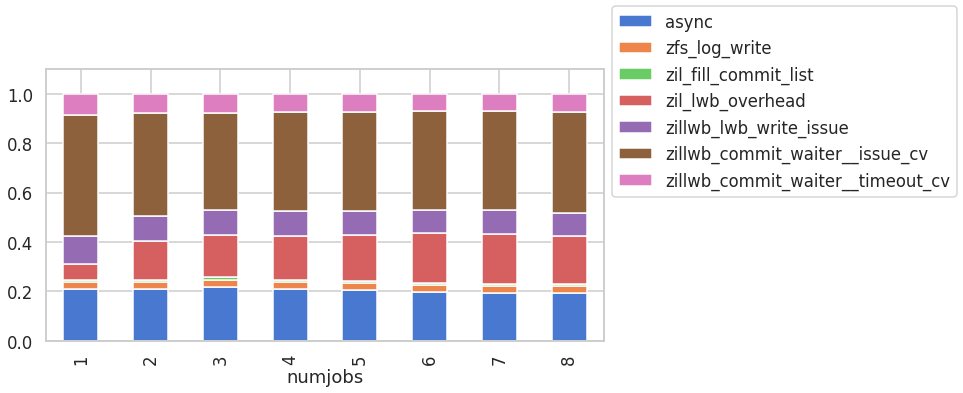

In [69]:
data = df_latbreakdown.copy()
total = data.sum(axis=1)
data = data.div(total, axis=0)
# display(data)

def plot(f, ax, legend):
    f.d.plot.bar(ax=ax, ylim=(0, 1.1), legend=False, stacked=True)
    if not f.is_last_row:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
    
factorplot(data, row=None, col=None, plot=plot, subplots_kw={
    "figsize": (10,5),
#     "gridspec_kw": {'hspace': 0.2},
})

display(data)

# Absolute Latency Normalized By IOPS

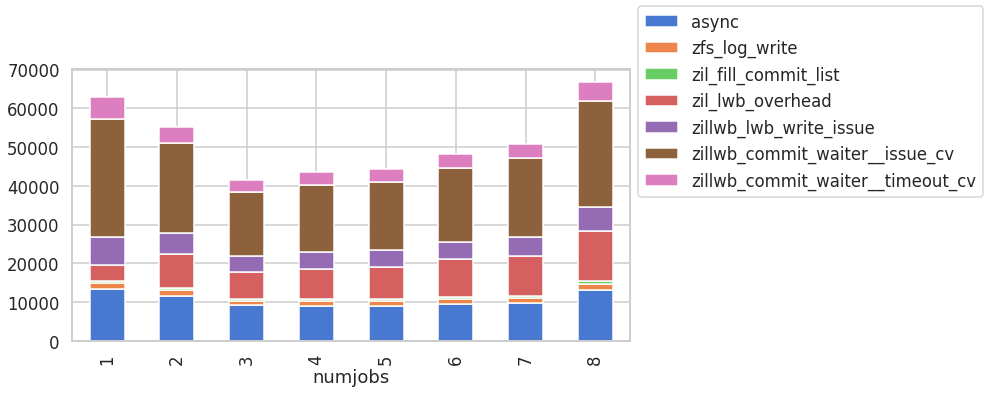

In [70]:
data = df_latbreakdown.div(df_fio.w_iops_mean, axis=0)
#data = df_latbreakdown

def plot(f, ax, legend):
    f.d.plot.bar(ax=ax, ylim=(0, None), legend=legend, stacked=True)
    if not f.is_last_row:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
    
factorplot(data, row=None, col=None, plot=plot, subplots_kw={
    "figsize": (10, 5),
    "gridspec_kw": {'hspace': 0.2},
})

<AxesSubplot:xlabel='numjobs'>

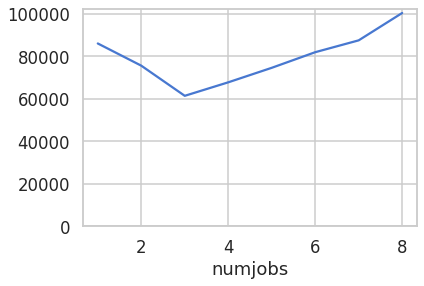

In [71]:
df_fio.w_lat_mean.plot(ylim=(0, None))

numjobs
1    62838.069772
2    55265.772041
3    41574.986470
4    43499.795117
5    44296.141258
6    48077.161055
7    50766.666091
8    66791.344303
dtype: float64

numjobs
1    23090.758281
2    20225.355568
3    19751.283662
4    24167.037150
5    30189.372428
6    33746.658557
7    36627.899909
8    33458.651429
dtype: float64

<AxesSubplot:xlabel='numjobs'>

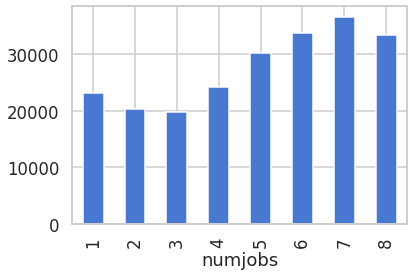

In [73]:
measured_total = df_latbreakdown.div(df_fio.w_iops_mean, axis=0).sum(axis=1)
display(measured_total)
measurement_error = df_fio.w_lat_mean - measured_total
display(measurement_error)
measurement_error.plot.bar()

<AxesSubplot:xlabel='numjobs'>

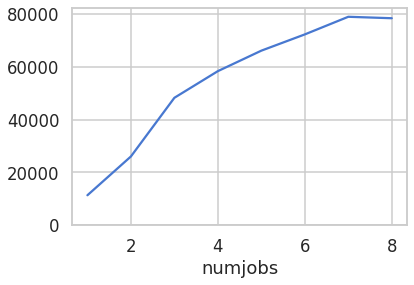

In [30]:
# for reference
df_fio.w_iops_mean.plot(ylim=(0, None))

# LWB merging

,zfs_write_count,lwb_issue_count
numjobs,,
1,11827,12587
2,22238,22247
3,26805,26814
4,33658,33672
5,36344,36356
6,39538,39555
7,42652,42671
8,53777,53797


<AxesSubplot:xlabel='numjobs'>

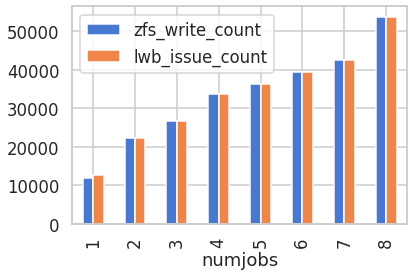

In [43]:
tmp = df.copy()
data = tmp[["zfs_write_count", "lwb_issue_count"]]
display(data)
data.plot.bar()

#  ZIO + PMEM latency when writing LWBs

,zfs_write_count,lwb_issue_count
numjobs,,
1,11827,12587
2,22238,22247
3,26805,26814
4,33658,33672
5,36344,36356
6,39538,39555
7,42652,42671
8,53777,53797


,zio_overhead,pmem_submit_bio
numjobs,,
1,253700376,86312255
2,411557635,149311482
3,540840207,188071569
4,703760028,246632172
5,815794686,280084222
6,974605993,325013087
7,1134878105,366330346
8,1511221766,485453889


<AxesSubplot:xlabel='numjobs'>

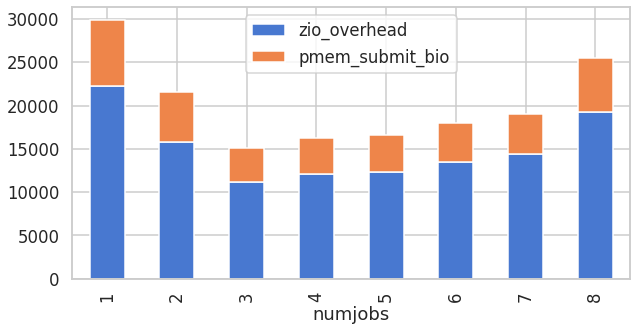

In [46]:
tmp = df.copy()

del tmp['fio_metrics']
del tmp['cpu']

tmp['interpolated_lwb_write_time'] = tmp.lwb_issue_count * tmp.last_lwb_latency

tmp['zio_overhead'] = tmp.interpolated_lwb_write_time - tmp.pmem_submit_bio

display(tmp[["zfs_write_count", "lwb_issue_count"]])

data = tmp[[
    "zio_overhead",
    "pmem_submit_bio",
]]
zio_overhead_vs_pmem_time = data
display(zio_overhead_vs_pmem_time)
# zio_overhead_vs_pmem_time.plot.bar(stacked=True, figsize=(10,5))

zio_overhead_vs_pmem_time.div(df_fio.w_iops_mean, axis=0).plot.bar(stacked=True, figsize=(10,5))
